# Multi-output Gaussian processes in GPflow

This notebook shows how to construct a multi-output GP model using GPflow, together with different interdomain inducing variables which lead to different approximation properties. GPflow provides a framework for specifying multioutput GP priors, and interdomain approximations which is
- modular, by providing a consistent interface for the user of the resulting `SVGP` model,
- extensible, by allowing new interdomain variables and kernels to be specified while reusing exising code where possible,
- efficient, by allowing the most efficient custom code path to be specified where desired.

Getting to grips with the maths and code can be a bit daunting, so to accompany the documentation there is an [in-depth review on arXiv](https://arxiv.org/abs/2003.01115), which provides a unified mathematical framework, together with a high-level description of software design choices in GPflow.

This notebook shows the various design choices that can be made, to show the reader the flexibility of the framework. This is done in the hope that an example is provided that can be easily adapted to the special case that the reader wants to implement.

A reader who just wants to use a multioutput kernel should simply choose the most efficient set of inducing variables.

To cite this framework, please reference our [arXiv paper](https://arxiv.org/abs/2003.01115).
```
@article{GPflow2020multioutput,
  author = {{van der Wilk}, Mark and Dutordoir, Vincent and John, ST and
            Artemev, Artem and Adam, Vincent and Hensman, James},
  title = {A Framework for Interdomain and Multioutput {G}aussian Processes},
  year = {2020},
  journal = {arXiv:2003.01115},
  url = {https://arxiv.org/abs/2003.01115}
}
```

\begin{equation}
\newcommand{\GP}{\mathcal{GP}}
\newcommand{\NN}{\mathcal{N}}
\newcommand{\LL}{\mathcal{L}}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\EE}{\mathbb{E}}
\newcommand{\valpha}{\boldsymbol\alpha}
\newcommand{\vf}{\mathbf{f}}
\newcommand{\vF}{\mathbf{F}}
\newcommand{\vg}{\mathbf{g}}
\newcommand{\vW}{\mathbf{W}}
\newcommand{\vI}{\mathbf{I}}
\newcommand{\vZ}{\mathbf{Z}}
\newcommand{\vu}{\mathbf{u}}
\newcommand{\vU}{\mathbf{U}}
\newcommand{\vX}{\mathbf{X}}
\newcommand{\vY}{\mathbf{Y}}
\newcommand{\identity}{\mathbb{I}}
\end{equation}



## Task
We will consider a regression problem for functions $f: \mathbb{R}^D \rightarrow \mathbb{R}^P$. We assume that the dataset is of the form $(X, f_1), \dots, (X, f_P)$, that is, we observe all the outputs for a particular input location (for cases where there are **not** fully observed outputs for each input, see [A simple demonstration of coregionalization](./coregionalisation.ipynb)).

Here we assume a model of the form:
\begin{equation}
f(x) = W g(x),
\end{equation}
where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$. We assume that the outputs of $g$ are uncorrelated, and that by *mixing* them with $W$ they become correlated. In this notebook, we show how to build this model using Sparse Variational Gaussian Process (SVGP) for $g$, which scales well with the numbers of data points and outputs.

Here we have two options for $g$:
1. The output dimensions of $g$ share the same kernel.
1. Each output of $g$ has a separate kernel.


In addition, we have two further suboptions for the inducing inputs of $g$:
1. The instances of $g$ share the same inducing inputs.
1. Each output of $g$ has its own set of inducing inputs.

The notation is as follows:
- $X \in \mathbb{R}^{N \times D}$ denotes the input
- $Y \in \RR^{N \times P}$ denotes the output
- $k_{1..L}$, $L$ are kernels on $\RR^{N \times D}$
- $g_{1..L}$, $L$ are independent $\GP$s  with $g_l \sim \GP(0,k_l)$
- $f_{1..P}$, $P$ are correlated  $\GP$s  with $\vf = \vW \vg$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow as gpf
import tensorflow as tf

from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter

gpf.config.set_default_float(np.float64)
gpf.config.set_default_summary_fmt("notebook")
np.random.seed(0)
%matplotlib inline

MAXITER = ci_niter(2000)

## Generate synthetic data
We create a utility function to generate synthetic data. We assume that:

In [2]:
N = 100  # number of points
D = 1  # number of input dimensions
M = 15  # number of inducing points
L = 2  # number of latent GPs
P = 3  # number of observations = output dimensions

In [3]:
def generate_data(N=100):
    X = np.random.rand(N)[:, None] * 10 - 5  # Inputs = N x D
    G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X))  # G = N x L
    W = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])  # L x P
    F = np.matmul(G, W)  # N x P
    Y = F + np.random.randn(*F.shape) * [0.2, 0.2, 0.2]

    return X, Y

In [4]:
X, Y = data = generate_data(N)
Zinit = np.linspace(-5, 5, M)[:, None]

We create a utility function for plotting:

In [5]:
def plot_model(m, lower=-8.0, upper=8.0):
    pX = np.linspace(lower, upper, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(X, Y, "x")
    plt.gca().set_prop_cycle(None)
    plt.plot(pX, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)
    plt.xlabel("X")
    plt.ylabel("f")
    plt.title(f"ELBO: {m.elbo(data):.3}")
    plt.plot(Z, Z * 0.0, "o")

## Model the outputs of $f(x)$ directly
The three following examples show how to model the outputs of the model $f(x)$ directly. Mathematically, this case is equivalent to having:
\begin{equation}
f(x) = I g(x),
\end{equation}
i.e. $W = I$ and $P = L$.

### 1. Shared independent multi-output kernel (MOK) and shared independent inducing variables
Here the priors on all outputs are constrained to have the same kernel hyperparameters. We also share the inducing inputs between all outputs. The different GPs are independent both in the prior and the approximate posterior.

In [6]:
# create multi-output kernel
kernel = gpf.kernels.SharedIndependent(
    gpf.kernels.SquaredExponential() + gpf.kernels.Linear(), output_dim=P
)
# initialization of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multi-output inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(Z)
)

In [7]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P)
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.inducing_variable.Z,Parameter,Identity,,True,"(15, 1)",float64,[[-5....
SVGP.q_mu,Parameter,Identity,,True,"(15, 3)",float64,"[[0., 0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 15, 15)",float64,"[[[1., 0., 0...."


In [8]:
def optimize_model_with_scipy(model):
    optimizer = gpf.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss_closure(data),
        variables=model.trainable_variables,
        method="l-bfgs-b",
        options={"disp": True, "maxiter": MAXITER},
    )


optimize_model_with_scipy(m)

In [9]:
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9279289483015759
SVGP.kernel.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.7983203097130618
SVGP.kernel.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.2131436477256385
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.039661360898887874
SVGP.inducing_variable.inducing_variable.Z,Parameter,Identity,,True,"(15, 1)",float64,[[-4.83958795...
SVGP.q_mu,Parameter,Identity,,True,"(15, 3)",float64,"[[-0.90123581, 0.69870771, -1.47433239..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 15, 15)",float64,"[[[1.71188624e-02, 0.00000000e+00, 0.00000000e+00..."


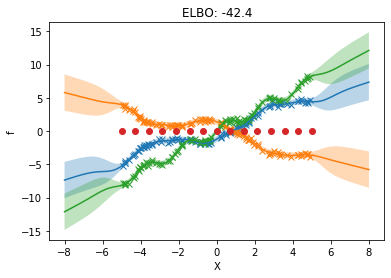

In [10]:
# Plot predictions and observations
plot_model(m)

In [11]:
print_summary(m.kernel)
m.kernel.kernel.kernels[0].lengthscales

name,class,transform,prior,trainable,shape,dtype,value
SharedIndependent.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.927929
SharedIndependent.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.79832
SharedIndependent.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.21314


<Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.7983203097130618>

### 2. Separate independent MOK and shared independent inducing variables
Here we allow different hyperparameters for the priors of each output. We still share the inducing inputs between all outputs.

In [12]:
# Create list of kernels for each output
kern_list = [gpf.kernels.SquaredExponential() + gpf.kernels.Linear() for _ in range(P)]
# Create multi-output kernel from kernel list
kernel = gpf.kernels.SeparateIndependent(kern_list)
# initialization of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multi-output inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(Z)
)

In [13]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P)

In [14]:
optimize_model_with_scipy(m)

Instructions for updating:
Use fn_output_signature instead


In [15]:
print_summary(m.kernel)

name,class,transform,prior,trainable,shape,dtype,value
SeparateIndependent.kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,0.860641
SeparateIndependent.kernels[0].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.934116
SeparateIndependent.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,0.859909
SeparateIndependent.kernels[1].kernels[0].variance,Parameter,Softplus,,True,(),float64,0.750561
SeparateIndependent.kernels[1].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.969375
SeparateIndependent.kernels[1].kernels[1].variance,Parameter,Softplus,,True,(),float64,0.528672
SeparateIndependent.kernels[2].kernels[0].variance,Parameter,Softplus,,True,(),float64,1.1112
SeparateIndependent.kernels[2].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.749108
SeparateIndependent.kernels[2].kernels[1].variance,Parameter,Softplus,,True,(),float64,2.21954


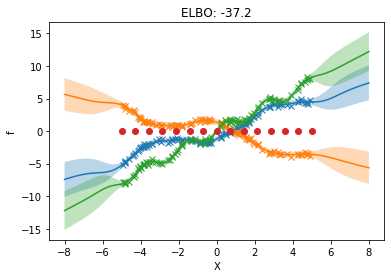

In [16]:
plot_model(m)

In [17]:
[k.kernels[0].lengthscales for k in m.kernel.kernels]

[<Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.9341163111123959>,
 <Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.9693754664194918>,
 <Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.749107650912927>]

### 3. Separate independent kernel and separate independent inducing variables
Here we allow different hyperparameters for the priors of each output. We now allow different inducing inputs for each output.

In [18]:
# Create list of kernels for each output
kern_list = [gpf.kernels.SquaredExponential() + gpf.kernels.Linear() for _ in range(P)]
# Create multi-output kernel from kernel list
kernel = gpf.kernels.SeparateIndependent(kern_list)
# initialization of inducing input locations, one set of locations per output
Zs = [Zinit.copy() for _ in range(P)]
# initialize as list inducing inducing variables
iv_list = [gpf.inducing_variables.InducingPoints(Z) for Z in Zs]
# create multi-output inducing variables from iv_list
iv = gpf.inducing_variables.SeparateIndependentInducingVariables(iv_list)

**NOTE:** While the inducing points are independent, there needs to be the same number of inducing points per dimension.

In [19]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P)

In [20]:
optimize_model_with_scipy(m)

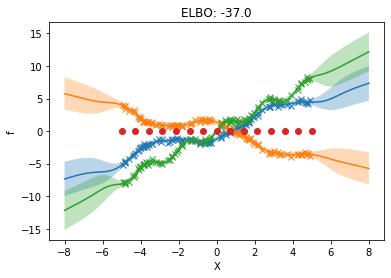

In [21]:
plot_model(m)

The following plot shows that we use different inducing *inputs* in each output dimension.

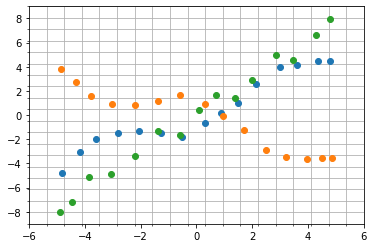

In [22]:
for i in range(len(m.inducing_variable.inducing_variable_list)):
    q_mu_unwhitened, q_var_unwhitened = m.predict_f(m.inducing_variable.inducing_variable_list[i].Z)
    plt.plot(
        m.inducing_variable.inducing_variable_list[i].Z.numpy(),
        q_mu_unwhitened[:, i, None].numpy(),
        "o",
    )
plt.gca().set_xticks(np.linspace(-6, 6, 20), minor=True)
plt.gca().set_yticks(np.linspace(-9, 9, 20), minor=True)
plt.grid(which="minor")

In [23]:
m.inducing_variable.inducing_variable_list

ListWrapper([<gpflow.inducing_variables.inducing_variables.InducingPoints object at 0x7fecfc0ef860>, <gpflow.inducing_variables.inducing_variables.InducingPoints object at 0x7fecfc0efdd8>, <gpflow.inducing_variables.inducing_variables.InducingPoints object at 0x7fecac377908>])

## Model $f(x)$ by doing inference in the $g$ space
### Mixed kernel and uncorrelated inducing variables

Remember the general case: $f(x) = W g(x)$, where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$, where $L \leq P$.
We assume that the outputs of $g$ are uncorrelated, and by *mixing* them with $W$ they become correlated.
With this setup we perform the optimal routine to calculate the conditional. Namely, calculate the conditional of the uncorrelated latent $g$ and afterwards project the mean and variance using the mixing matrix: $\mu_f = W \mu_g$ and $\Sigma_f = W\Sigma_g W^\top$

- $K_{uu} = L \times M \times M$
- $K_{uf} = L \times M \times N$

In [24]:
# Create list of kernels for each output
kern_list = [gpf.kernels.SquaredExponential() + gpf.kernels.Linear() for _ in range(L)]
# Create multi-output kernel from kernel list
kernel = gpf.kernels.LinearCoregionalization(
    kern_list, W=np.random.randn(P, L)
)  # Notice that we initialise the mixing matrix W
# initialisation of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multi-output inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(Z)
)

In [25]:
# initialize mean of variational posterior to be of shape MxL
q_mu = np.zeros((M, L))
# initialize \sqrt(Σ) of variational posterior to be of shape LxMxM
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0

# create SVGP model as usual and optimize
m = gpf.models.SVGP(
    kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, q_mu=q_mu, q_sqrt=q_sqrt
)

In [26]:
optimize_model_with_scipy(m)

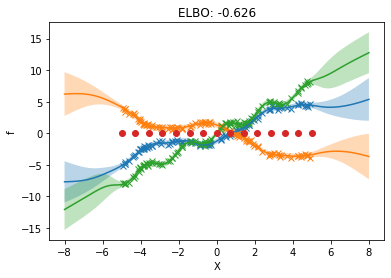

In [27]:
plot_model(m)

## Illustration of GPflow's multi-output capabilities
This section shows the inheritance structure in GPflow's multi-output framework.

### Multi-output kernels (MOK) class diagram
We include three multi-output kernels:
- `SharedIndependent`: This kernel is included mainly as an illustration of specifying a conditional using the multiple dispatch framework. The same functionality is provided by using a normal kernel and passing in multiple approximate posteriors by stacking `q_mu` and `q_sqrt`.
- `SeparateIndependent`: This kernel allows you to use different priors for each output GP.
- `LinearCoregionalization`: This kernel describes the prior of the linear model of coregionalization. As shown previously, this implementation supports various inducing point approximations.
![Multi-output kernels](./multioutput_kernels.svg)

We include several base classes. Two are noteworthy:
- `MultioutputKernel` is included to be the base class for all multi-output kernels.
- `IndepedentLatent` is the base class for all multi-output kernels which are constructed from independent latent processes. Including this kernel allows the specification of a default approximation method which, while not the most efficient, does take advantage of _some_ structure. It can be applied to _any_ kernel constructed from independent latent processes.

There is a similarity in the meaning of `SeparateIndependent` and `IndependentLatent`. Both kernels indicate that independent processes are used, and that $\mathbf{K}_{\bf uu}$ can therefore be represented as a `[L, M, M]` tensor. It could therefore be suggested that `SeparateIndependent` be the parent class of all "independent latent" kernels, instead of having a separate `IndependentLatent` class. We decided against this because:
- this would increase the complexity in specifying `conditionals()` for the otherwise simple multi-output kernels `SeparateIndependent` and `SharedIndependent`.
- we did not want to specify too much of an implementation in `IndependentLatent`, leaving implementation details to child classes. Using `SeparateIndependent` as the base class would force all child classes to be a `Combination` kernel.

### Multi-output inducing variables class diagram
![Multi-output features](./multioutput_features.svg)

#### Inducing points
The goal of this class is to provide inducing variables that can be used with _any_ kernel, even if the method ends up being slow.

The multiouput framework extends `InducingPoints` to work with multi-output kernels. Just like for single-output kernels, we want `InducingPoints` to work for all `MultioutputKernel`s. We do this by defining `InducingPoints` to take _all_ outputs for specific inducing inputs as inducing variables.

#### Fallback shared/separate independent inducing variables
The goal of these classes is to provide a reasonably efficient implementation for kernels that give exploitable independence structure in the prior of inducing variables (that is, subclasses of `IndependentLatent`), while only needing to implement `Kuu()` and `Kuf()` methods.

#### Shared/separate independent inducing variables
The goal of these classes is to provide the most efficient code path for kernels that allow exploiting independence structure in the prior of inducing variables.

For more specialized multi-output kernels (i.e. `{Shared|Separate}Independent` or `LinearCoregionalization`) we define `{Shared|Separate}IndependentInducingVariables`. These wrap (a list of) single-output inducing variables to define groups of a-priori independent inducing variables, which leads to a $\mathbf{K}_{\bf uu}$ that can be represented as a `[L, M, M]` tensor. We saw the use of these previously.

`{Shared|Separate}IndependentInducingVariables` inherit from `Fallback{Shared|Separate}IndependentInducingVariables`, so the multiple dispatch will fall back on the slower but general implementation.

### Implemented combinations
Multiple dispatch is applied to both `Kuu()`, `Kuf()`, and `conditional()`. The return values of the covariances can therefore be tailored to a specific implementation of `conditional()`. The following table lists combinations which are currently available in GPflow. Thanks to the multiple dispatch code, implementing your own outside of GPflow should require only a small amount of code!

| Inducing variable class                                      | Kernel                  | Kuu           | Kuf           | conditional                         | note                                                                                                                                                                                                                                                                                           |
|----------------------------------------------|-------------------------|---------------|---------------|-------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `InducingPoints`                               | `MultioutputKernel`       | `[M, P, M, P]` | `[M, P, N, P]` | `inducing_point_conditional()`, which calls `fully_correlated_conditional()`       | Works for all kernels, but might be very inefficient. In this case `q_mu` and `q_sqrt` should have shapes of `[1, MP]` and `[1, MP, MP]`  |
| `SharedIndependentInducingVariables`           | `SharedIndependent`       | `[M, M]`         | `[M, N]`         | `shared_independent_conditional()`, which calls `base_conditional()`                    | The combination of these two classes is in a sense redundant, because we can achieve the same behavior by using the single output Kernel and InducingVariable classes. They are added for illustrative purposes. Thanks to the conditional dispatch, the most efficient code path is used. |
| `SeparateIndependentInducingVariables`         | `SharedIndependent`       | `[P, M, M]`     | `[P, M, N]`     | `separate_independent_conditional()`, which calls `base_conditional()` P times               | We loop P times over the `base_conditional()`         |
| `SeparateIndependentInducingVariable`         | `SeparateIndependent`     | `[P, M, M]`     | `[P, M, N]`     |  `separate_independent_conditional()`, which calls `base_conditional()` P times                | We loop P times over the `base_conditional()`           |
| `SharedIndependentInducingVariables`           | `SeparateIndependent`     | `[P, M, M]`     | `[P, M, N]`     | `separate_independent_conditional()`, which calls `base_conditional()` P times                | We loop P times over the `base_conditional()`        |
| `FallbackSharedIndependentInducingVariables`   | `IndependentLatent`       | `[L, M, M]`     | `[M, L, N, P]` | `fallback_independent_latent_conditional()`, which calls `independent_interdomain_conditional()` | Implementation which only requires custom `Kuu()` and `Kuf()` |
| `FallbackSeparateIndependentInducingVariable` | `IndependentLatent`       | `[L, M, M]`     | `[M, L, N, P]` | `fallback_independent_latent_conditional()`, which calls `independent_interdomain_conditional()` | Implementation which only requires custom `Kuu()` and `Kuf()`  |
| `SharedIndependentInducingVariables`           | `LinearCoregionalization` | `[L, M, M]`     | `[L, M, N]`     | `coregionalization_conditional()`, which calls `base_conditional()`                    | This is the most efficient implementation for linear coregionalization. The inducing outputs live in g-space. Here we use the output of the base conditional and project the mean and covariance with the mixing matrix W.                                                                    |
| `SeparateIndependentInducingVariables`         | `LinearCoregionalization` | `[L, M, M]`     | `[L, M, N]`     | base_conditional                    | This is the most efficient implementation for linear coregionalization. The inducing outputs live in g-space. Here we use the output of the base conditional and project the mean and covariance with the mixing matrix W.                                                                    |

## Debugging: introspect

Given all these possibilities it can be hard to determine which conditional will be called for which set of kernel and inducing variable. The following method lets you proactively introspect which implementation will be executed. This can be useful when debugging new code.

In [28]:
def inspect_conditional(inducing_variable_type, kernel_type):
    """
    Helper function returning the exact implementation called
    by the multiple dispatch `conditional` given the type of
    kernel and inducing variable.

    :param inducing_variable_type:
        Type of the inducing variable
    :param kernel_type:
        Type of the kernel

    :return: String
        Contains the name, the file and the linenumber of the
        implementation.
    """
    import inspect
    from gpflow.conditionals import conditional

    implementation = conditional.dispatch(object, inducing_variable_type, kernel_type, object)
    info = dict(inspect.getmembers(implementation))
    return info["__code__"]


# Example:
inspect_conditional(
    gpf.inducing_variables.SharedIndependentInducingVariables, gpf.kernels.SharedIndependent
)

<code object shared_independent_conditional at 0x7fed6960ced0, file "/usr/local/lib/python3.6/site-packages/gpflow/conditionals/multioutput/conditionals.py", line 45>

## Further Reading:
- [A simple demonstration of coregionalization](./coregionalisation.ipynb), which details other GPflow features for multi-output prediction without fully observed outputs.